Yeast! Woohoo!

In [47]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2
from nn.preprocess import *
from nn.nn import NeuralNetwork
from nn.io import *

### Read in data

In [3]:
positive = read_text_file('data/rap1-lieb-positives.txt')
negative = read_fasta_file('data/yeast-upstream-1k-negative.fa')

In [4]:
len(positive[0])

17

In [5]:
#making negative sequences the same length as positive seqs: 
#randomly selecting 17 bp from each negative seq
new_length = 17
np.random.seed(13)
negative_shortened = []

for seq in negative:
    new_start = np.random.randint(0, len(seq)-new_length)
    negative_shortened += [seq[new_start:new_start+new_length]]


In [6]:
len(positive), len(negative_shortened)

(137, 3163)

### Sample sequences

Randomly samples the positive samples with replacement to match number of negative sequences.

In [7]:
all_seqs = positive+negative_shortened

#1 = positive, 0 = negative
all_labels = [1]*len(positive)+[0]*len(negative_shortened)

sampled_seqs, sampled_labels = sample_seqs(all_seqs, all_labels)

In [8]:
Counter(sampled_labels)

Counter({0: 3163, 1: 3163})

### One hot encode sequences

In [9]:
seqs_one_hot = one_hot_encode_seqs(sampled_seqs)

In [10]:
seqs_one_hot[0]

array([0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.])

### Split data into training and validation sets

80% training, 20% validation

In [11]:
#shuffle
np.random.seed(1)
idxs = np.arange(len(seqs_one_hot))
np.random.shuffle(idxs)
seqs_shuffled = np.array(seqs_one_hot,dtype=object)[idxs]
labels_shuffled = np.array(sampled_labels,dtype=object)[idxs]

#split
split_on = round(len(seqs_one_hot)*.8)

seqs_train = seqs_shuffled[:split_on]
labels_train = labels_shuffled[:split_on]

seqs_val = seqs_shuffled[split_on:]
labels_val = labels_shuffled[split_on:]

seqs_train.shape, labels_train.shape, seqs_val.shape, labels_val.shape

((5061, 68), (5061,), (1265, 68), (1265,))

### Train NN:

-I chose sigmoid as the activation function because this is a classification problem, and my inputs/outputs are binary.

-I chose binary cross entropy as the loss function because we want a probability distribution (probability of positive or negative) as the output.

-I didn't find that the output size of the first layer mattered much (but sizes larger than 64 made the model very slow). The second layer is a 1D array because the labels are 1D.

-I tuned the model (see below) and chose the parameters that gave the best validation loss. The learning rate of 0.1 seemed to have the strongest effect on the outcome.

In [57]:
hyperparam_tune = []

for lr in [0.1, 0.01, 0.001, 0.0001]:
    for epoch in [10, 100, 200]:
        for batch_size in [50, 250, 500]:

            model = NeuralNetwork(nn_arch =  [{'input_dim': 68, 'output_dim': 32, 'activation': 'sigmoid'},
                                  {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}],
                          lr = lr, seed = 1, batch_size = batch_size, 
                          epochs = epoch, loss_function='mse')

            per_epoch_loss_train, per_epoch_loss_val = model.fit(seqs_train, labels_train, seqs_val, labels_val)

            final_train_loss = min(per_epoch_loss_train)
            final_val_loss = min(per_epoch_loss_val)

            hyperparam_tune += [[lr, epoch, batch_size, final_train_loss, final_val_loss]]


In [58]:
df = pd.DataFrame(hyperparam_tune)
df.columns = ['LR', 'num_epochs', 'batch_size', 'train_MSE', 'val_MSE']

In [59]:
df.sort_values('val_MSE').head(5)

,LR,num_epochs,batch_size,train_MSE,val_MSE
6,0.1,200,50,0.000911,0.000439
3,0.1,100,50,0.001595,0.000930
7,0.1,200,250,0.003051,0.002416
8,0.1,200,500,0.005167,0.004732
4,0.1,100,250,0.005397,0.004967


### Plotting training and validation loss for best model:

In [60]:
def plot_loss(per_epoch_loss_train, per_epoch_loss_val):
    
    plt.plot(per_epoch_loss_train, label='training')
    plt.plot(per_epoch_loss_val, label='validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (BCE)')
    plt.legend()
    
    plt.show()

In [63]:
lr = 0.1
batch_size = 50
epoch = 200


model = NeuralNetwork(nn_arch =  [{'input_dim': 68, 'output_dim': 32, 'activation': 'sigmoid'},
                                  {'input_dim': 32, 'output_dim': 1, 'activation': 'sigmoid'}],
                          lr = lr, seed = 1, batch_size = batch_size, 
                          epochs = epoch, loss_function='mse')

per_epoch_loss_train, per_epoch_loss_val =  model.fit(seqs_train, labels_train, seqs_val, labels_val)

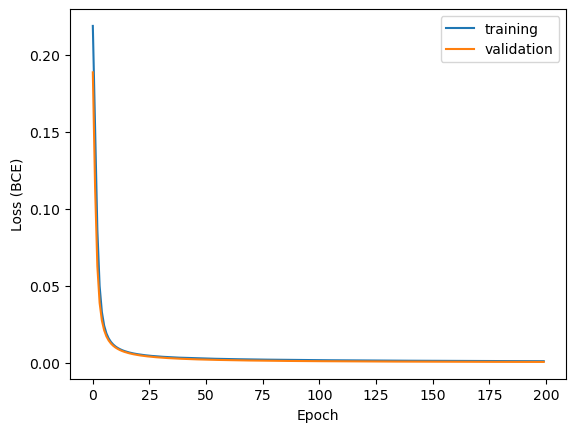

In [64]:
plot_loss(per_epoch_loss_train, per_epoch_loss_val)

### Accuracy of classifier on validation data

In [65]:
pred = model.predict(seqs_val)

In [66]:
#convert predictions to binary values like the labels
pred_binary = np.where(pred.squeeze() < .5, 0, 1)

In [67]:
#accuracy
len(np.where(labels_val == pred_binary)[0])/len(labels_val)

1.0